# Figures for Yeager et al., 2025: Efficient Drift Correction of Initialized Earth System Predictions
### CESM2-SMYLE and E3SMv2.1-SMYLE sea level pressure analysis

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
import nc_time_axis
%matplotlib inline

# import plotting and other utilities 
# https://github.com/sgyeager/mypyutils
from mypyutils import calendar_utils as cal
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import regrid_utils as regrid
from mypyutils import io_utils as io
from mypyutils import stat_utils as stat

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [46]:
try:
    client.shutdown()
except:
    pass

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='32GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=32GB',
        account='P06010014',
        walltime='02:30:00',
        local_directory='/glade/derecho/scratch/yeager/',
        log_directory='/glade/derecho/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": 1.0,
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(50) 
client

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35305 instead
  warnings.warn(


<Client: 'tcp://128.117.208.180:44487' processes=0 threads=0, memory=0 B>

### Read in CESM2-SMYLE SLP monthly data

In [3]:
datadir = '/glade/derecho/scratch/yeager/YeagerEA_EffDriftCorr/data/'

In [4]:
cesm_smyle11 = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.SLP.1970-2020.nc').chunk({'M':1})
cesm_smyle11['SLP'] = cesm_smyle11['SLP'].astype('float32')

In [5]:
cesm_smyle11_climoic = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.SLP.climoIC.nc').chunk({'M':1})
cesm_smyle11_climoic['SLP'] = cesm_smyle11_climoic['SLP'].astype('float32')

### Read in E3SM2-SMYLE SLP monthly data

In [6]:
e3sm_smyle11 = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.SLP.1970-2020.nc').chunk({'M':1})
e3sm_smyle11['SLP'] = e3sm_smyle11['SLP'].astype('float32')

In [7]:
e3sm_smyle11_climoic = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.SLP.climoIC.nc').chunk({'M':1})
e3sm_smyle11_climoic['SLP'] = e3sm_smyle11_climoic['SLP'].astype('float32')

### Observed PSL

In [8]:
era5 = xr.open_dataset(datadir+'ERA5.SLP.1959-2023.fv09.nc').astype('float32')

## Obs monthly anomalies

In [10]:
climy0 = 1991
climy1 = 2020

In [11]:
def monthly_anomaly(da, y0, y1, output='anomaly', groupby_type="time.month"):
    gb = da.groupby(groupby_type)
    clim = da.sel(time=slice(str(y0),str(y1))).groupby(groupby_type).mean(dim="time")
    anom = gb - clim
    if output=='anomaly':
        da_out = anom
    else:
        da_out = clim
    return da_out

In [12]:
%%time
tmp = era5['SLP']
obs_mon_clim = monthly_anomaly(tmp,climy0,climy1,'clim').compute()
obs_mon_anom = tmp.map_blocks(monthly_anomaly, args=[climy0,climy1,'anomaly'], template=tmp).compute()

CPU times: user 151 ms, sys: 64.9 ms, total: 216 ms
Wall time: 233 ms


### De-drift (using various methods)

In [13]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1991
climy1 = 2020
cesm_smyle11_time = cesm_smyle11.time.load()
cesm_smyle11_anom_meth2,cesm_smyle11_clim = stat.remove_drift(cesm_smyle11['SLP'],cesm_smyle11_time,climy0,climy1)

CPU times: user 518 ms, sys: 35.4 ms, total: 553 ms
Wall time: 4.21 s


In [14]:
%%time
# Method 2, but only 1 member
iterations = 100
cesm_smyle11_anom_meth2_1mem,cesm_smyle11_clim_1mem = stat.remove_drift_nmem(cesm_smyle11['SLP'].drop_vars('M'),cesm_smyle11_time,climy0,climy1,1,iterations)

CPU times: user 6.94 s, sys: 38.4 ms, total: 6.98 s
Wall time: 7.65 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [15]:
%%time
# Method 2, but only 3 member
iterations = 100
cesm_smyle11_anom_meth2_3mem,cesm_smyle11_clim_3mem = stat.remove_drift_nmem(cesm_smyle11['SLP'].drop_vars('M'),cesm_smyle11_time,climy0,climy1,3,iterations)

CPU times: user 7.75 s, sys: 0 ns, total: 7.75 s
Wall time: 8.38 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [16]:
## Use Method 3 to compute anomalies (subtract climoIC ensemble):
cesm_smyle11_anom_meth3 = cesm_smyle11['SLP'] - cesm_smyle11_climoic['SLP'].mean('M').squeeze()

In [17]:
## Use Method 1 to compute anomalies (subtract observed climo):
obs_climo = cesm_smyle11_climoic['SLP'].mean('M').squeeze().copy()
mons = cesm_smyle11_time.sel(Y=2005).dt.month.values
for i in range(24):
    thismonth=mons[i]
    obs_climo.loc[dict(L=(i+1))] = obs_mon_clim.sel(month=thismonth)
obs_climo = obs_climo.load()
cesm_smyle11_anom_meth1 = cesm_smyle11['SLP'] - obs_climo

In [18]:
## rechunk
e3sm_smyle11 = e3sm_smyle11.chunk({'Y':1})

In [20]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1991
climy1 = 2020
e3sm_smyle11_time = e3sm_smyle11.time.load()
e3sm_smyle11_anom_meth2,e3sm_smyle11_clim = stat.remove_drift(e3sm_smyle11['SLP'],e3sm_smyle11_time,climy0,climy1)

CPU times: user 42.7 ms, sys: 8.48 ms, total: 51.2 ms
Wall time: 116 ms


In [21]:
%%time
# Method 2, but only 1 member
iterations = 100
e3sm_smyle11_anom_meth2_1mem,e3sm_smyle11_clim_1mem = stat.remove_drift_nmem(e3sm_smyle11['SLP'].drop_vars('M'),e3sm_smyle11_time,climy0,climy1,1,iterations)

CPU times: user 7.58 s, sys: 3.06 ms, total: 7.58 s
Wall time: 8.4 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 100
  result = blockwise(


In [22]:
%%time
# Method 2, but only 3 member
iterations = 100
e3sm_smyle11_anom_meth2_3mem,e3sm_smyle11_clim_3mem = stat.remove_drift_nmem(e3sm_smyle11['SLP'].drop_vars('M'),e3sm_smyle11_time,climy0,climy1,3,iterations)

CPU times: user 8.68 s, sys: 8.57 ms, total: 8.69 s
Wall time: 9.28 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 100
  result = blockwise(


In [23]:
# Use Method 3 to compute anomalies (subtract climoIC ensemble):
e3sm_smyle11_anom_meth3 = e3sm_smyle11['SLP'] - e3sm_smyle11_climoic['SLP'].mean('M').squeeze()

In [24]:
## Use Method 1 to compute anomalies (subtract observed climo):
e3sm_smyle11_anom_meth1 = e3sm_smyle11['SLP'] - obs_climo

## Latlon Bias Comparison Plot

In [25]:
lon = cesm_smyle11.lon
lat = cesm_smyle11.lat

In [26]:
%%time
cesm_climobias2 = cesm_smyle11_clim - obs_climo
cesm_climobias2 = cesm_climobias2.load()

CPU times: user 2.26 s, sys: 168 ms, total: 2.43 s
Wall time: 20.7 s


In [27]:
%%time
e3sm_climobias2 = e3sm_smyle11_clim - obs_climo
e3sm_climobias2 = e3sm_climobias2.load()

CPU times: user 3.06 s, sys: 187 ms, total: 3.24 s
Wall time: 18.4 s


In [28]:
%%time
cesm_climobias2_1mem = cesm_smyle11_clim_1mem - obs_climo

CPU times: user 9.11 ms, sys: 0 ns, total: 9.11 ms
Wall time: 16.7 ms


In [29]:
%%time
e3sm_climobias2_1mem = e3sm_smyle11_clim_1mem - obs_climo

CPU times: user 8.99 ms, sys: 52 μs, total: 9.04 ms
Wall time: 9.06 ms


In [30]:
%%time
cesm_climobias2_3mem = cesm_smyle11_clim_3mem - obs_climo
#cesm_climobias2_3mem = cesm_climobias2_3mem.load()

CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 25.2 ms


In [31]:
%%time
e3sm_climobias2_3mem = e3sm_smyle11_clim_3mem - obs_climo
#e3sm_climobias2_3mem = e3sm_climobias2_3mem.load()

CPU times: user 10.2 ms, sys: 3.77 ms, total: 13.9 ms
Wall time: 26.1 ms


In [32]:
%%time
cesm_climobias3 = cesm_smyle11_climoic['SLP'].mean('M').squeeze() - obs_climo
cesm_climobias3 = cesm_climobias3.load()

CPU times: user 96.2 ms, sys: 14.9 ms, total: 111 ms
Wall time: 409 ms


In [33]:
%%time
e3sm_climobias3 = e3sm_smyle11_climoic['SLP'].mean('M').squeeze() - obs_climo
e3sm_climobias3 = e3sm_climobias3.load()

CPU times: user 91 ms, sys: 11.8 ms, total: 103 ms
Wall time: 539 ms


## Supplementary Figure 11

CPU times: user 49.9 s, sys: 58.5 ms, total: 50 s
Wall time: 54.3 s


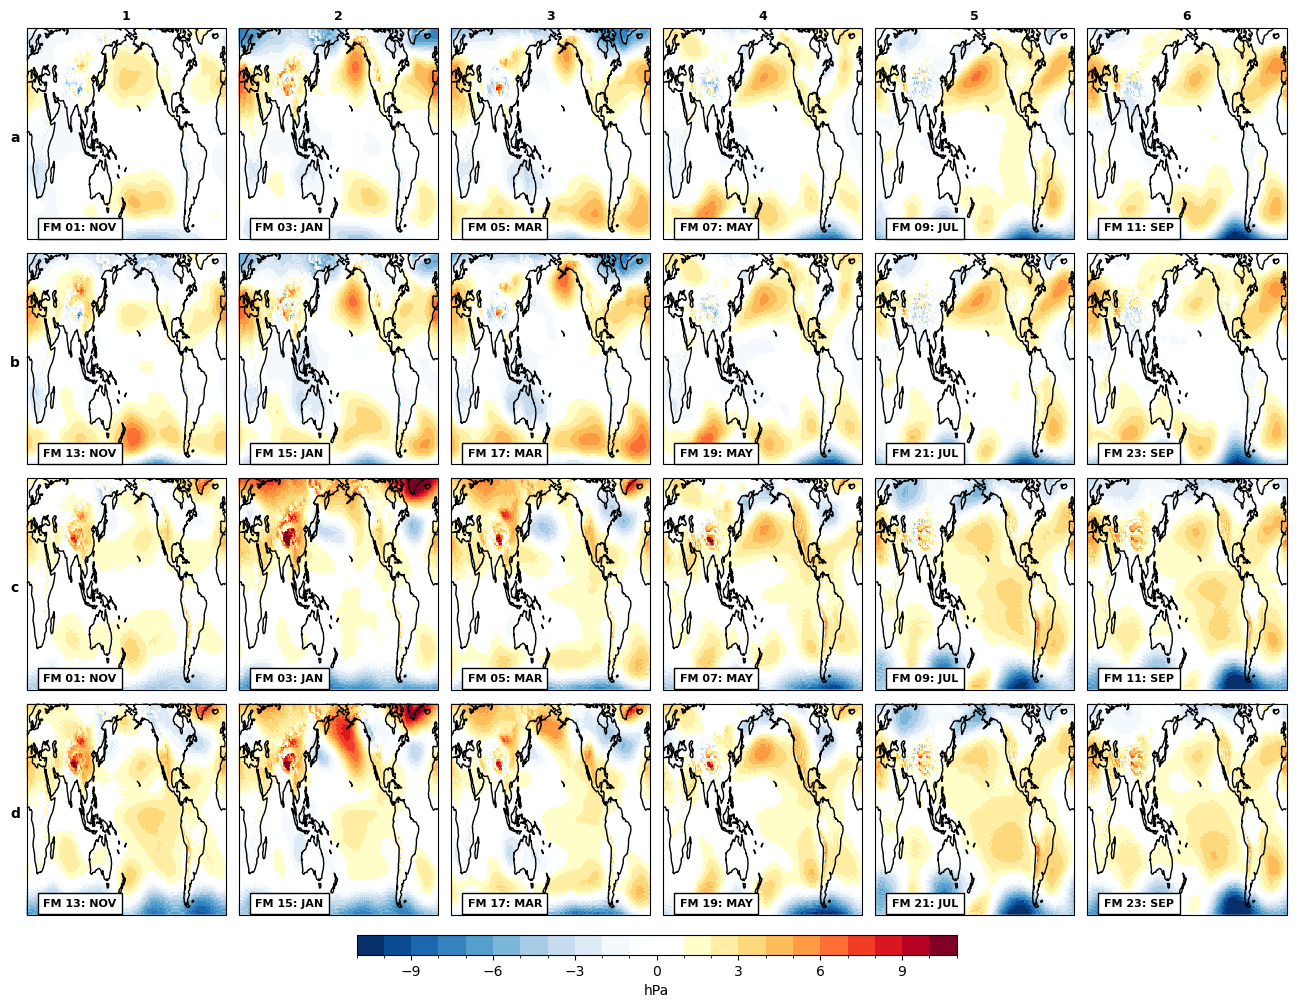

In [34]:
%%time
ci = 1
cmin = -11
cmax = 11

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, cesm_climobias2.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, e3sm_climobias2.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'hPa', orientation='horizontal')

plt.savefig('Fig_supp11.png')

In [35]:
%%time
cesm_msss3 = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth3,cesm_smyle11_anom_meth2,nleads=23,resamp=0,detrend=False)
cesm_msss3 = cesm_msss3.load()

CPU times: user 4.81 s, sys: 288 ms, total: 5.1 s
Wall time: 15.9 s


In [36]:
%%time
cesm_msss1 = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth1,cesm_smyle11_anom_meth2,nleads=23,resamp=0,detrend=False)
cesm_msss1 = cesm_msss1.load()

CPU times: user 5.76 s, sys: 340 ms, total: 6.1 s
Wall time: 22.7 s


In [37]:
%%time
chunks = {'M':1,'Y':-1}
cesm_msss2_1mem = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth2_1mem.chunk(chunks),cesm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False)
cesm_msss2_1mem = cesm_msss2_1mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 15.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 16s, sys: 5.23 s, total: 2min 21s
Wall time: 2min 54s


In [38]:
%%time
chunks = {'M':1,'Y':-1}
cesm_msss2_3mem = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth2_3mem.chunk(chunks),cesm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False)
cesm_msss2_3mem = cesm_msss2_3mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 22.25 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 41s, sys: 4.07 s, total: 2min 45s
Wall time: 3min 4s


In [39]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss1 = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth1.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss1 = e3sm_msss1.load()

CPU times: user 9.67 s, sys: 422 ms, total: 10.1 s
Wall time: 24.6 s


In [40]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss3 = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth3.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss3 = e3sm_msss3.load()

CPU times: user 7.18 s, sys: 472 ms, total: 7.65 s
Wall time: 22.7 s


In [41]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss2_1mem = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth2_1mem.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss2_1mem = e3sm_msss2_1mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 20.07 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 45s, sys: 8.78 s, total: 3min 54s
Wall time: 6min 14s


In [42]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss2_3mem = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth2_3mem.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss2_3mem = e3sm_msss2_3mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 26.90 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 41s, sys: 5.72 s, total: 3min 46s
Wall time: 4min 38s


## Supplementary Figure 12

CPU times: user 49.5 s, sys: 190 ms, total: 49.7 s
Wall time: 54.1 s


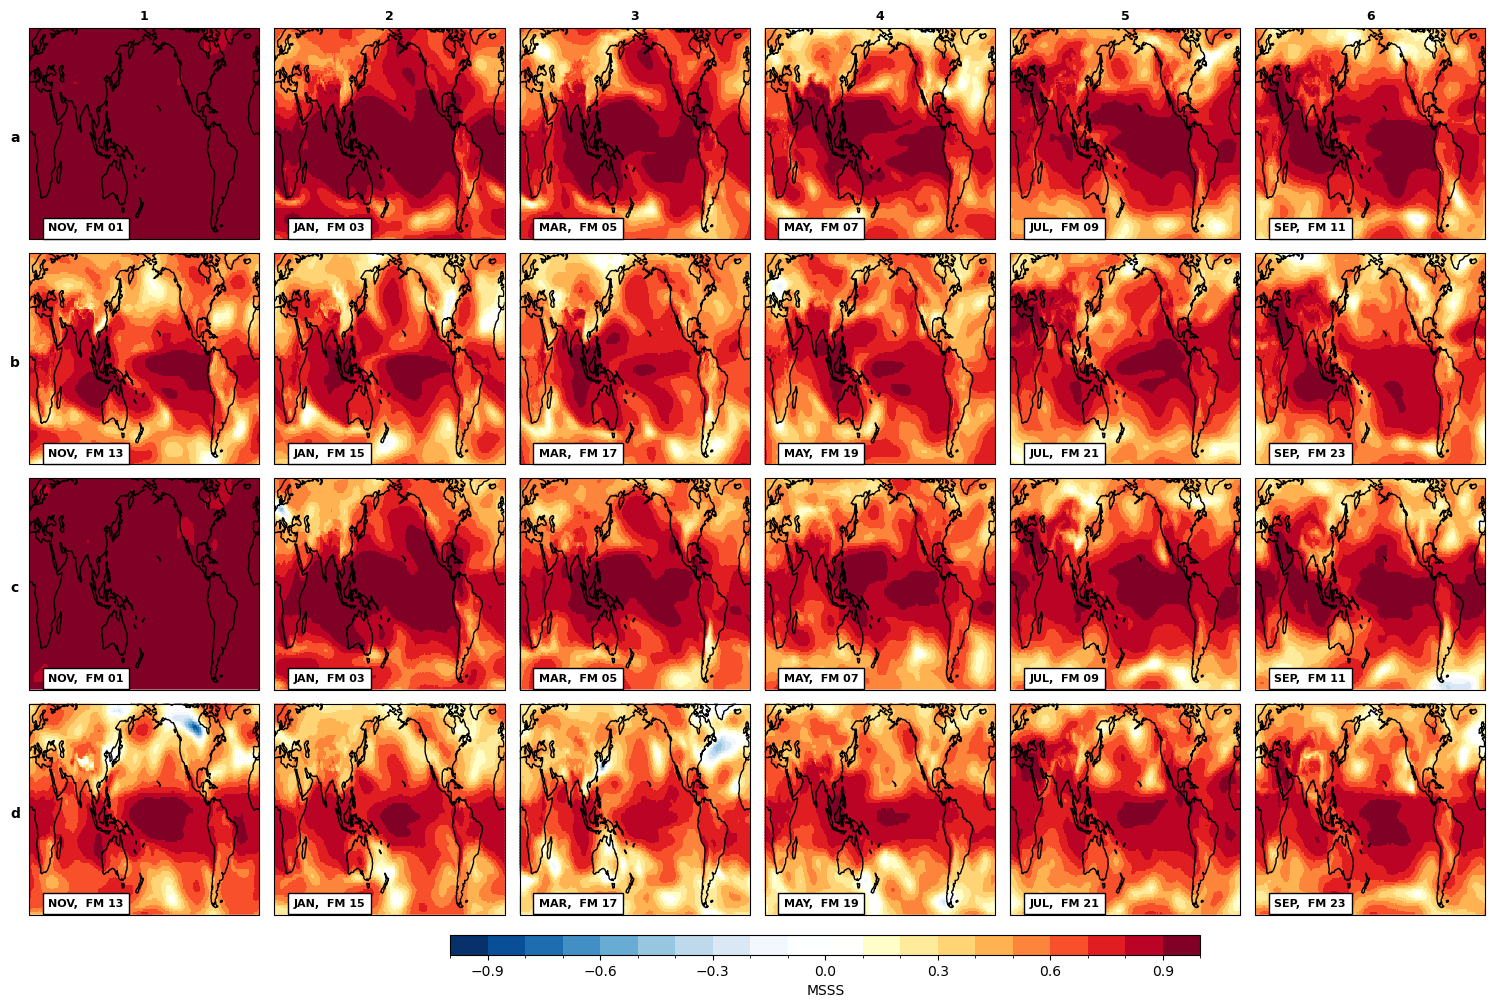

In [43]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss2_1mem['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss2_1mem['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp12.png')

## Supplementary Figure 13

CPU times: user 49.9 s, sys: 190 ms, total: 50.1 s
Wall time: 54.5 s


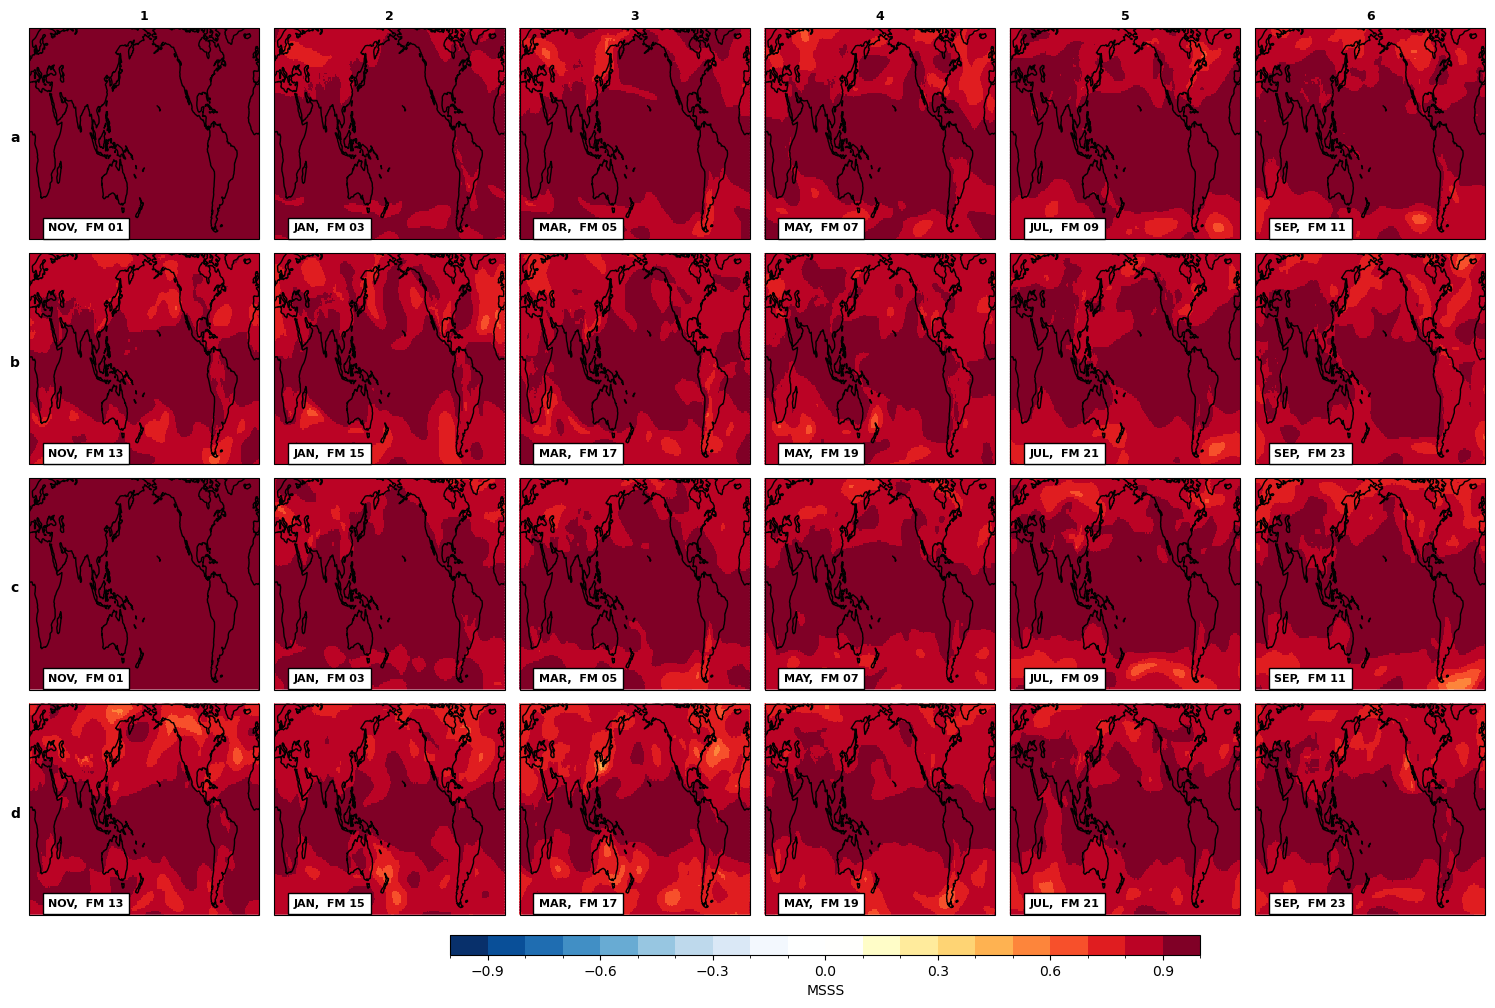

In [44]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss2_3mem['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss2_3mem['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp13.png')

## Supplementary Figure 14

CPU times: user 50 s, sys: 127 ms, total: 50.2 s
Wall time: 54.6 s


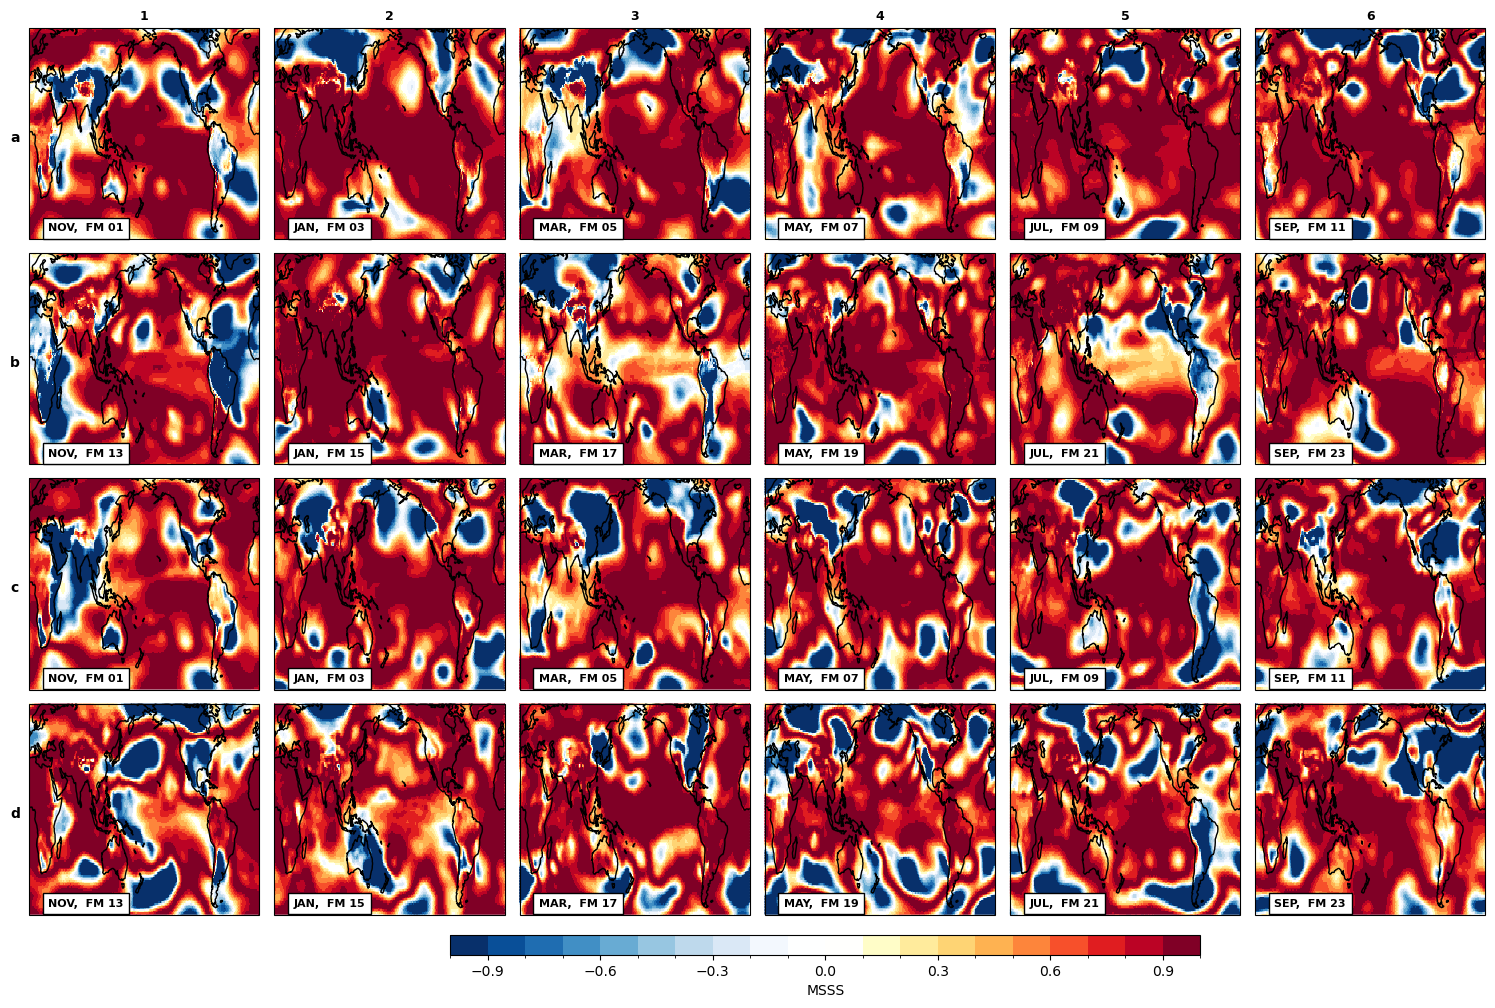

In [45]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss3['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss3['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp14.png')